# Data Prep

This notebook contains the code required for preparing, cleaning, and exploring the BikeShare demand dataset.

## Imports

In [3]:
import os
import io
import json
from dateutil.parser import parse
import pandas as pd
import numpy as np
import requests
import sys
from datetime import datetime, timedelta
from dateutil import rrule
import matplotlib.pyplot as plt
import holidays
import seaborn as sns

## Functions

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%y-%m-%d %H:%M')
dateparse_timezone = lambda x: datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S')

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))
    
def getHourlyData(stationID, year, month):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=16)

def getData(stationID, year, month):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=0)    

## Data Source: Weather Data from GC

### Batch import weather data

In [ ]:
stationID = 48549

start_date = datetime.strptime('Jan2020', '%b%Y')
end_date = datetime.strptime('Feb2022', '%b%Y')
data_range = [dt for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date)]

frames = []
for dt in data_range:
    df = getData(stationID, dt.year, dt.month)
    frames.append(df)
    
weather_data = pd.concat(frames)

In [ ]:
weather_data.shape

(18960, 30)

### Clean-up Weather Data


1.   Drop unwanted cols
2.   Fix data type(s)
3.   Imputation



In [ ]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18960 entries, 0 to 671
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude (x)        18960 non-null  float64
 1   Latitude (y)         18960 non-null  float64
 2   Station Name         18960 non-null  object 
 3   Climate ID           18960 non-null  int64  
 4   Date/Time (LST)      18960 non-null  object 
 5   Year                 18960 non-null  int64  
 6   Month                18960 non-null  int64  
 7   Day                  18960 non-null  int64  
 8   Time (LST)           18960 non-null  object 
 9   Temp (°C)            18921 non-null  float64
 10  Temp Flag            18 non-null     object 
 11  Dew Point Temp (°C)  18896 non-null  float64
 12  Dew Point Temp Flag  44 non-null     object 
 13  Rel Hum (%)          18906 non-null  float64
 14  Rel Hum Flag         34 non-null     object 
 15  Precip. Amount (mm)  18940 non-null  f

In [ ]:
weather_data.iloc[1,:]

Longitude (x)                        -79.4
Latitude (y)                         43.63
Station Name           TORONTO CITY CENTRE
Climate ID                         6158359
Date/Time (LST)           2020-01-01 01:00
Year                                  2020
Month                                    1
Day                                      1
Time (LST)                           01:00
Temp (°C)                              0.1
Temp Flag                              NaN
Dew Point Temp (°C)                   -4.0
Dew Point Temp Flag                    NaN
Rel Hum (%)                           74.0
Rel Hum Flag                           NaN
Precip. Amount (mm)                    0.0
Precip. Amount Flag                    NaN
Wind Dir (10s deg)                    25.0
Wind Dir Flag                          NaN
Wind Spd (km/h)                       34.0
Wind Spd Flag                          NaN
Visibility (km)                       16.1
Visibility Flag                        NaN
Stn Press (

In [ ]:
weather_data.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

In [ ]:
cols_to_keep = ['Date/Time (LST)','Temp (°C)', 'Precip. Amount (mm)','Wind Spd (km/h)','Wind Dir (10s deg)','Visibility (km)','Weather']

In [ ]:
weather_data_clean = weather_data[cols_to_keep]

In [ ]:
weather_data_clean['Date/Time (LST)'] = weather_data_clean['Date/Time (LST)'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
weather_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18960 entries, 0 to 671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date/Time (LST)      18960 non-null  datetime64[ns]
 1   Temp (°C)            18921 non-null  float64       
 2   Precip. Amount (mm)  18940 non-null  float64       
 3   Wind Spd (km/h)      18925 non-null  float64       
 4   Wind Dir (10s deg)   18024 non-null  float64       
 5   Visibility (km)      18928 non-null  float64       
 6   Weather              2704 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.2+ MB


In [ ]:
# Temperature: missing value is filled by last valid observation since data is organized chronologically
weather_data_clean['Temp (°C)']=weather_data_clean['Temp (°C)'].fillna(method='ffill')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Precipitation: missing value is filled by 0 - no precipitation
weather_data_clean['Precip. Amount (mm)']=weather_data_clean['Precip. Amount (mm)'].fillna(0.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
weather_data_clean['Wind Spd (km/h)']=weather_data_clean['Wind Spd (km/h)'].fillna(method='ffill')
weather_data_clean['Wind Dir (10s deg)']=weather_data_clean['Wind Dir (10s deg)'].fillna(method='ffill')
weather_data_clean['Visibility (km)']=weather_data_clean['Visibility (km)'].fillna(method='ffill')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
weather_data_clean['Weather'] = weather_data_clean['Weather'].fillna('Other')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
weather_data_clean.iloc[319:327]['Wind Spd (km/h)']

,Date/Time (LST),Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Weather
319,2020-01-14 07:00:00,1.3,0.0,28.0,9.0,16.1,NaN
320,2020-01-14 08:00:00,1.6,0.0,NaN,NaN,16.1,NaN
321,2020-01-14 09:00:00,2.2,0.0,22.0,9.0,16.1,NaN
322,2020-01-14 10:00:00,2.3,0.0,24.0,10.0,16.1,NaN
323,2020-01-14 11:00:00,2.3,0.0,NaN,NaN,16.1,NaN
324,2020-01-14 12:00:00,2.3,0.0,26.0,8.0,16.1,NaN
325,2020-01-14 13:00:00,2.3,0.0,26.0,7.0,NaN,NaN
326,2020-01-14 14:00:00,1.3,0.0,NaN,NaN,9.7,NaN


In [ ]:
weather_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18960 entries, 0 to 671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date/Time (LST)      18960 non-null  datetime64[ns]
 1   Temp (°C)            18960 non-null  float64       
 2   Precip. Amount (mm)  18960 non-null  float64       
 3   Wind Spd (km/h)      18960 non-null  float64       
 4   Wind Dir (10s deg)   18960 non-null  float64       
 5   Visibility (km)      18960 non-null  float64       
 6   Weather              18960 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.2+ MB


### Add Features from Weather data

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date_time_local      100001 non-null  datetime64[ns]
 1   unixtime             100001 non-null  int64         
 2   pressure_station     99970 non-null   float64       
 3   pressure_sea         99970 non-null   float64       
 4   wind_dir             77579 non-null   object        
 5   wind_dir_10s         99135 non-null   float64       
 6   wind_speed           99972 non-null   float64       
 7   wind_gust            17794 non-null   float64       
 8   relative_humidity    99952 non-null   float64       
 9   dew_point            99957 non-null   float64       
 10  temperature          99965 non-null   float64       
 11  windchill            22911 non-null   float64       
 12  humidex              16372 non-null   float64       
 13  visibility    

In [ ]:
cols_to_add = ['date_time_local','wind_speed', 'temperature','windchill','visibility']
df_combined = pd.merge(df, weather[cols_to_add], how='left',left_on='Rounded_Start_Time', right_on='date_time_local')

In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945169 entries, 0 to 945168
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Trip Id              945169 non-null  int64         
 1   Trip  Duration       945169 non-null  int64         
 2   Start Station Id     945169 non-null  int64         
 3   Start Time           945169 non-null  datetime64[ns]
 4   Start Station Name   945169 non-null  object        
 5   End Station Id       945169 non-null  int64         
 6   End Time             945169 non-null  object        
 7   End Station Name     945169 non-null  object        
 8   Bike Id              945169 non-null  int64         
 9   User Type            945169 non-null  object        
 10  orig_coords          945169 non-null  object        
 11  dest_coords          945169 non-null  object        
 12  Origin Address       945169 non-null  object        
 13  Destination Ad

In [ ]:
df_combined[df_combined['date_time_local'].isnull()]

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,...,Origin Address,Destination Address,Duration (s),Distance (m),Rounded_Start_Time,date_time_local,wind_speed,temperature,windchill,visibility


## Data Source: Toronto Bike Share Data

In [ ]:
data_path = "../data/01_trip_data_2020-01_2022-02.csv"
df_trip_data = pd.read_csv(data_path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_trip_data.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,7334128,648,7003,01/01/2020 00:08,Madison Ave / Bloor St W,7271.0,01/01/2020 00:19,Yonge St / Alexander St - SMART,3104,Annual Member
1,7334129,419,7007,01/01/2020 00:10,College St / Huron St,7163.0,01/01/2020 00:17,Yonge St / Wood St,2126,Annual Member
2,7334130,566,7113,01/01/2020 00:13,Parliament St / Aberdeen Ave,7108.0,01/01/2020 00:22,Front St E / Cherry St,4425,Annual Member
3,7334131,1274,7333,01/01/2020 00:17,King St E / Victoria St,7311.0,01/01/2020 00:38,Sherbourne St / Isabella St,4233,Annual Member
4,7334132,906,7009,01/01/2020 00:19,King St E / Jarvis St,7004.0,01/01/2020 00:34,University Ave / Elm St,2341,Casual Member


In [ ]:
df_trip_data.tail()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
6610260,14964896,139,7055,02/28/2022 23:56,Jarvis St / Carlton St,7443.0,02/28/2022 23:58,Dundas St E / George St,4354,Annual Member
6610261,14964899,1098,7143,02/28/2022 23:57,Kendal Ave / Bernard Ave,7143.0,03/01/2022 00:15,Kendal Ave / Bernard Ave,5575,Annual Member
6610262,14964900,459,7450,02/28/2022 23:57,Carlaw Ave / Danforth Ave,7340.0,03/01/2022 00:05,Blake St / Boultbee Ave,4169,Annual Member
6610263,14964903,410,7473,02/28/2022 23:58,Adelaide St W / Strachan Ave,7017.0,03/01/2022 00:05,Widmer St / Adelaide St W,4117,Annual Member
6610264,14964904,743,7178,02/28/2022 23:59,Dundas St W / Edna Ave,7496.0,03/01/2022 00:12,Sunnyside Ave / The Queensway - SMART,2232,Annual Member


### Fix Start Station Id Type

Data type of station ID in certain cells was float. Coverted all to string and replaced '.0'

In [ ]:
#Data type of station ID in certain cells was float. Converted all to string and replaced '.0'
df_trip_data['Start Station Id'] = df_trip_data['Start Station Id'].astype(str)
df_trip_data['Start Station Id'] = df_trip_data['Start Station Id'].map(lambda x: x.replace('.0',''))
df_trip_data['Start Station Id']

0          7003
1          7007
2          7113
3          7333
4          7009
           ... 
6647662    7065
6647663    7292
6647664    7065
6647665    7233
6647666    7057
Name: Start Station Id, Length: 6647667, dtype: object

In [ ]:
#Data type of station ID in certain cells was float. Coverted all to string and replaced '.0'
df_trip_data['End Station Id'] = df_trip_data['End Station Id'].astype(str)
df_trip_data['End Station Id'] = df_trip_data['End Station Id'].map(lambda x: x.replace('.0',''))
df_trip_data['End Station Id']

0          7271
1          7163
2          7108
3          7311
4          7004
           ... 
6647662    7472
6647663    7076
6647664    7472
6647665    7569
6647666    7383
Name: End Station Id, Length: 6647667, dtype: object

In [ ]:
df_trip_data.describe(include = 'all')

,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
count,6647667,6647667,6641158,6647667,6647667,6637372,6.647594e+06,6647667
unique,631,839990,737,633,839569,741,NaN,2
top,7076,05/15/2021 13:38,York St / Queens Quay W,7076,05/16/2021 16:13,York St / Queens Quay W,NaN,Annual Member
freq,62667,100,62667,70088,78,70088,NaN,4125658
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.739091e+03,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,1.927957e+03,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.400000e+01,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.208000e+03,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.961000e+03,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5.383000e+03,NaN


### Parse Time Columns to Datetime Type

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M')
df_trip_data['Start Time Fixed'] = df_trip_data['Start Time'].apply(dateparse)
df_trip_data['End Time Fixed'] = df_trip_data['End Time'].apply(dateparse)

In [ ]:
df_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6647667 entries, 0 to 6647666
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Trip  Duration      float64       
 1   Start Station Id    object        
 2   Start Time          object        
 3   Start Station Name  object        
 4   End Station Id      object        
 5   End Time            object        
 6   End Station Name    object        
 7   Bike Id             float64       
 8   User Type           object        
 9   Start Time Fixed    datetime64[ns]
 10  End Time Fixed      datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(7)
memory usage: 557.9+ MB


In [ ]:
df_trip_data.isna().sum()

Trip  Duration          247
Start Station Id          0
Start Time                0
Start Station Name     6509
End Station Id            0
End Time                  0
End Station Name      10295
Bike Id                  73
User Type                 0
Start Time Fixed          0
End Time Fixed            0
dtype: int64

In [ ]:
df_trip_data[df_trip_data['End Station Id'].isna()]

,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Start Time Fixed,End Time Fixed


### Filter out erroneous trips

Trips less than 2 mins in duration or having same station as start/end are filtered out

In [ ]:
# Dropping na entries - End Station Id is null or Trip Duration 0 - assume Bikes were taken out of rotation
df_trip_data = df_trip_data.dropna()
df_trip_data = df_trip_data[(df_trip_data['Trip  Duration'] > 120) & (df_trip_data['Start Station Id'] != df_trip_data['End Station Id'])]

In [ ]:
# Confirm all bad trips are removed
df_trip_data[~((df_trip_data['Trip  Duration'] > 120) & (df_trip_data['Start Station Id'] != df_trip_data['End Station Id']))]

,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Start Time Fixed,End Time Fixed


In [ ]:
df_trip_data

,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Start Time Fixed,End Time Fixed
0,648.0,7003,01/01/2020 00:08,Madison Ave / Bloor St W,7271,01/01/2020 00:19,Yonge St / Alexander St - SMART,3104.0,Annual Member,2020-01-01 00:08:00,2020-01-01 00:19:00
1,419.0,7007,01/01/2020 00:10,College St / Huron St,7163,01/01/2020 00:17,Yonge St / Wood St,2126.0,Annual Member,2020-01-01 00:10:00,2020-01-01 00:17:00
2,566.0,7113,01/01/2020 00:13,Parliament St / Aberdeen Ave,7108,01/01/2020 00:22,Front St E / Cherry St,4425.0,Annual Member,2020-01-01 00:13:00,2020-01-01 00:22:00
3,1274.0,7333,01/01/2020 00:17,King St E / Victoria St,7311,01/01/2020 00:38,Sherbourne St / Isabella St,4233.0,Annual Member,2020-01-01 00:17:00,2020-01-01 00:38:00
4,906.0,7009,01/01/2020 00:19,King St E / Jarvis St,7004,01/01/2020 00:34,University Ave / Elm St,2341.0,Casual Member,2020-01-01 00:19:00,2020-01-01 00:34:00
...,...,...,...,...,...,...,...,...,...,...,...
6647662,355.0,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472,01/01/2022 00:02,Dundas St E / Victoria St,4574.0,Casual Member,2021-12-31 23:56:00,2022-01-01 00:02:00
6647663,770.0,7292,12/31/2021 23:56,Granby St / Church St - SMART,7076,01/01/2022 00:09,York St / Queens Quay W,5879.0,Annual Member,2021-12-31 23:56:00,2022-01-01 00:09:00
6647664,372.0,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472,01/01/2022 00:02,Dundas St E / Victoria St,3487.0,Casual Member,2021-12-31 23:56:00,2022-01-01 00:02:00
6647665,762.0,7233,12/31/2021 23:56,King / Cowan Ave - SMART,7569,01/01/2022 00:08,Toronto Inukshuk Park,4195.0,Annual Member,2021-12-31 23:56:00,2022-01-01 00:08:00


In [ ]:
df_trip_data.describe(include ='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Start Time Fixed,End Time Fixed
count,6.176704e+06,6.176704e+06,6176704,6176704,6176704,6176704,6176704,6176704,6176704.0,6176704,6176704,6176704
unique,NaN,NaN,622,858375,738,623,857381,741,12799.0,2,858375,857381
top,NaN,NaN,7076,05/15/2021 13:38,York St / Queens Quay W,7076,05/16/2021 16:13,York St / Queens Quay W,5880.0,Annual Member,2021-05-15 13:38:00,2021-05-16 16:13:00
freq,NaN,NaN,57181,94,57181,64489,65,64489,1536.0,3932241,94,65
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:08:00,2020-01-01 00:17:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-28 23:59:00,2022-03-01 00:26:00
mean,1.114087e+07,1.016074e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.205193e+06,5.527425e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.334128e+06,1.210000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.226889e+06,4.700000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Compute Net Demand per Station

In [ ]:
df_trip_data_start = df_trip_data.copy()
df_trip_data_start['Net Demand'] = 1

df_trip_data_end = df_trip_data.copy()
df_trip_data_end['Start Time Fixed'] = df_trip_data_end['End Time Fixed']
df_trip_data_end['Start Station Id'] = df_trip_data_end['End Station Id']
df_trip_data_end['Net Demand'] = -1

In [ ]:
df_trip_data_net_demand = pd.concat([df_trip_data_start, df_trip_data_end], axis = 0)

In [ ]:
df_trip_data_net_demand

,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Start Time Fixed,End Time Fixed,Net Demand
0,648.0,7003,01/01/2020 00:08,Madison Ave / Bloor St W,7271,01/01/2020 00:19,Yonge St / Alexander St - SMART,3104.0,Annual Member,2020-01-01 00:08:00,2020-01-01 00:19:00,1
1,419.0,7007,01/01/2020 00:10,College St / Huron St,7163,01/01/2020 00:17,Yonge St / Wood St,2126.0,Annual Member,2020-01-01 00:10:00,2020-01-01 00:17:00,1
2,566.0,7113,01/01/2020 00:13,Parliament St / Aberdeen Ave,7108,01/01/2020 00:22,Front St E / Cherry St,4425.0,Annual Member,2020-01-01 00:13:00,2020-01-01 00:22:00,1
3,1274.0,7333,01/01/2020 00:17,King St E / Victoria St,7311,01/01/2020 00:38,Sherbourne St / Isabella St,4233.0,Annual Member,2020-01-01 00:17:00,2020-01-01 00:38:00,1
4,906.0,7009,01/01/2020 00:19,King St E / Jarvis St,7004,01/01/2020 00:34,University Ave / Elm St,2341.0,Casual Member,2020-01-01 00:19:00,2020-01-01 00:34:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6647662,355.0,7472,12/31/2021 23:56,Dundas St E / Parliament St,7472,01/01/2022 00:02,Dundas St E / Victoria St,4574.0,Casual Member,2022-01-01 00:02:00,2022-01-01 00:02:00,-1
6647663,770.0,7076,12/31/2021 23:56,Granby St / Church St - SMART,7076,01/01/2022 00:09,York St / Queens Quay W,5879.0,Annual Member,2022-01-01 00:09:00,2022-01-01 00:09:00,-1
6647664,372.0,7472,12/31/2021 23:56,Dundas St E / Parliament St,7472,01/01/2022 00:02,Dundas St E / Victoria St,3487.0,Casual Member,2022-01-01 00:02:00,2022-01-01 00:02:00,-1
6647665,762.0,7569,12/31/2021 23:56,King / Cowan Ave - SMART,7569,01/01/2022 00:08,Toronto Inukshuk Park,4195.0,Annual Member,2022-01-01 00:08:00,2022-01-01 00:08:00,-1


In [ ]:
df_trip_data_net_demand.columns

Index(['Start Station Id', 'Start Time', 'Start Station Name',
       'End Station Id', 'End Time', 'End Station Name', 'Bike Id',
       'User Type', 'Start Time Fixed', 'End Time Fixed', 'Net Demand'],
      dtype='object')

In [ ]:
df_trip_data_net_demand = df_trip_data_net_demand.rename(columns={"Start Time Fixed": "Time"})
df_trip_data_net_demand = df_trip_data_net_demand[['Start Station Id', 'Time','User Type', 'Net Demand']]
df_trip_data_net_demand

,Start Station Id,Time,User Type,Net Demand
0,7003,2020-01-01 00:08:00,Annual Member,1
1,7007,2020-01-01 00:10:00,Annual Member,1
2,7113,2020-01-01 00:13:00,Annual Member,1
3,7333,2020-01-01 00:17:00,Annual Member,1
4,7009,2020-01-01 00:19:00,Casual Member,1
...,...,...,...,...
6647662,7472,2022-01-01 00:02:00,Casual Member,-1
6647663,7076,2022-01-01 00:09:00,Annual Member,-1
6647664,7472,2022-01-01 00:02:00,Casual Member,-1
6647665,7569,2022-01-01 00:08:00,Annual Member,-1


### Save Net Demand Per Station Dataset

In [ ]:
data_path = "../data/02_trip_data_2020-01_2022-02_new.csv"
df_trip_data_net_demand.to_csv(data_path, index=False)

## Data Cleaning

### Load Trip Dataset

In [ ]:
data_path = "../data/02_trip_data_2020-01_2022-02_new.csv"
df_trip_data = pd.read_csv(data_path, index_col=[0], parse_dates=['Time'])
df_trip_data.rename({'Time':'Start Time'}, inplace = True, axis = 1)

In [ ]:
df_trip_data.head()

,Start Time,User Type,Net Demand
Start Station Id,,,
7003,2020-01-01 00:08:00,Annual Member,1
7007,2020-01-01 00:10:00,Annual Member,1
7113,2020-01-01 00:13:00,Annual Member,1
7333,2020-01-01 00:17:00,Annual Member,1
7009,2020-01-01 00:19:00,Casual Member,1


In [ ]:
df_trip_data.tail()

,Start Time,User Type,Net Demand
Start Station Id,,,
7472,2022-01-01 00:02:00,Casual Member,-1
7076,2022-01-01 00:09:00,Annual Member,-1
7472,2022-01-01 00:02:00,Casual Member,-1
7569,2022-01-01 00:08:00,Annual Member,-1
7383,2022-01-01 00:21:00,Annual Member,-1


In [ ]:
df_trip_data.reset_index(inplace = True)

In [ ]:
df_trip_data.count()

Start Station Id    12425182
Start Time          12425182
User Type           12425182
Net Demand          12425182
dtype: int64

### Bin Trips into Timeframes

In [ ]:
df_trip_data['Start_Date'] = df_trip_data['Start Time'].apply(lambda x: hour_rounder(x))

In [ ]:
df_trip_data['datehour'] = df_trip_data['Start_Date'].dt.hour

In [ ]:
day_mapping = {0:'10PM-2AM',1:'2AM-6AM', 2:'6AM-10AM', 3:'10AM-2PM',4:'2PM-6PM', 5: '6PM-10PM', 6:'10PM-2AM'}
def hour_bin(i):
      return ((i%24)+2)//4

In [ ]:
df_trip_data['Binned_Start_Time'] = df_trip_data['datehour'].apply(hour_bin).map(day_mapping)

In [ ]:
df_trip_data.drop(columns = ['Start Time', 'datehour'], inplace = True)

In [ ]:
df_trip_data

,Start Station Id,User Type,Net Demand,Start_Date,Binned_Start_Time
0,7003,Annual Member,1,2020-01-01,10PM-2AM
1,7007,Annual Member,1,2020-01-01,10PM-2AM
2,7113,Annual Member,1,2020-01-01,10PM-2AM
3,7333,Annual Member,1,2020-01-01,10PM-2AM
4,7009,Casual Member,1,2020-01-01,10PM-2AM
...,...,...,...,...,...
12425177,7472,Casual Member,-1,2022-01-01,10PM-2AM
12425178,7076,Annual Member,-1,2022-01-01,10PM-2AM
12425179,7472,Casual Member,-1,2022-01-01,10PM-2AM
12425180,7569,Annual Member,-1,2022-01-01,10PM-2AM


In [ ]:
df_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12425182 entries, 0 to 12425181
Data columns (total 5 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Start Station Id   int64         
 1   User Type          object        
 2   Net Demand         int64         
 3   Start_Date         datetime64[ns]
 4   Binned_Start_Time  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 474.0+ MB


In [ ]:
df_trip_data['Start_Date'] = df_trip_data['Start_Date'].dt.date

In [ ]:
df_trip_data.head()


,Start Station Id,User Type,Net Demand,Start_Date,Binned_Start_Time
0,7003,Annual Member,1,2020-01-01,10PM-2AM
1,7007,Annual Member,1,2020-01-01,10PM-2AM
2,7113,Annual Member,1,2020-01-01,10PM-2AM
3,7333,Annual Member,1,2020-01-01,10PM-2AM
4,7009,Casual Member,1,2020-01-01,10PM-2AM


In [ ]:
df_trip_data['Start Station Id'] = df_trip_data['Start Station Id'].astype(str)

In [ ]:
df_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12425182 entries, 0 to 12425181
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Start Station Id   object
 1   User Type          object
 2   Net Demand         int64 
 3   Start_Date         object
 4   Binned_Start_Time  object
dtypes: int64(1), object(4)
memory usage: 474.0+ MB


### Importing Station Info

In [ ]:
url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information.json'
resp = requests.get(url)
station_info = json.loads(resp.text)

In [ ]:
df_station_info = pd.json_normalize(station_info, record_path=['data','stations'])

In [ ]:
df_station_info['station_id'] = df_station_info['station_id'].astype(str)

In [ ]:
df_station_info.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
1,7001,Wellesley Station Green P,REGULAR,43.664964,-79.383550,0.0,Yonge / Wellesley,17,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],416-617-9576,500.0,M4Y 1G7,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9615,500.0,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-631-4587,500.0,NaN,NaN
4,7004,University Ave / Elm St,REGULAR,43.656518,-79.389099,NaN,University Ave / Elm St,11,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[P7004-7047],647-643-9673,500.0,NaN,NaN


In [ ]:
df_station_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   station_id              618 non-null    object 
 1   name                    618 non-null    object 
 2   physical_configuration  618 non-null    object 
 3   lat                     618 non-null    float64
 4   lon                     618 non-null    float64
 5   altitude                608 non-null    float64
 6   address                 618 non-null    object 
 7   capacity                618 non-null    int64  
 8   rental_methods          618 non-null    object 
 9   groups                  618 non-null    object 
 10  obcn                    618 non-null    object 
 11  nearby_distance         618 non-null    float64
 12  post_code               303 non-null    object 
 13  cross_street            31 non-null     object 
dtypes: float64(4), int64(1), object(9)
memory 

In [ ]:
all_stations = list(df_station_info['station_id'].unique())

In [ ]:
all_stations

['7000',
 '7001',
 '7002',
 '7003',
 '7004',
 '7005',
 '7006',
 '7007',
 '7008',
 '7009',
 '7010',
 '7011',
 '7012',
 '7013',
 '7014',
 '7015',
 '7016',
 '7017',
 '7018',
 '7019',
 '7020',
 '7021',
 '7022',
 '7023',
 '7024',
 '7025',
 '7026',
 '7027',
 '7028',
 '7029',
 '7030',
 '7031',
 '7032',
 '7033',
 '7034',
 '7035',
 '7036',
 '7037',
 '7038',
 '7039',
 '7040',
 '7041',
 '7042',
 '7043',
 '7044',
 '7045',
 '7046',
 '7047',
 '7048',
 '7049',
 '7050',
 '7052',
 '7053',
 '7054',
 '7055',
 '7056',
 '7057',
 '7058',
 '7059',
 '7060',
 '7061',
 '7062',
 '7063',
 '7064',
 '7065',
 '7066',
 '7067',
 '7068',
 '7069',
 '7070',
 '7071',
 '7072',
 '7073',
 '7074',
 '7075',
 '7076',
 '7077',
 '7078',
 '7079',
 '7083',
 '7084',
 '7085',
 '7086',
 '7087',
 '7088',
 '7089',
 '7090',
 '7091',
 '7092',
 '7093',
 '7094',
 '7095',
 '7096',
 '7097',
 '7098',
 '7099',
 '7100',
 '7101',
 '7102',
 '7103',
 '7104',
 '7105',
 '7106',
 '7107',
 '7108',
 '7109',
 '7110',
 '7111',
 '7112',
 '7113',
 '7114',
 

In [ ]:
len(all_stations)

618

In [ ]:
trip_stations = list(df_trip_data['Start Station Id'].unique())

In [ ]:
len(trip_stations)

623

In [ ]:
missing_stations = [i for i in trip_stations if i not in all_stations]

In [ ]:
missing_stations

['7470',
 '7402',
 '7116',
 '7481',
 '7051',
 '7436',
 '7358',
 '7456',
 '7254',
 '7510',
 '7573',
 '7649',
 '7651',
 '7532',
 '7394',
 '7638']

In [ ]:
# dropping stations that didn't have information in the station cross-reference. Opensource data has not been updated since 2021
df_trip_data_trim = df_trip_data[~df_trip_data['Start Station Id'].isin(missing_stations)]

In [ ]:
df_trip_data_trim

,Start Station Id,User Type,Net Demand,Start_Date,Binned_Start_Time
0,7003,Annual Member,1,2020-01-01,10PM-2AM
1,7007,Annual Member,1,2020-01-01,10PM-2AM
2,7113,Annual Member,1,2020-01-01,10PM-2AM
3,7333,Annual Member,1,2020-01-01,10PM-2AM
4,7009,Casual Member,1,2020-01-01,10PM-2AM
...,...,...,...,...,...
12425177,7472,Casual Member,-1,2022-01-01,10PM-2AM
12425178,7076,Annual Member,-1,2022-01-01,10PM-2AM
12425179,7472,Casual Member,-1,2022-01-01,10PM-2AM
12425180,7569,Annual Member,-1,2022-01-01,10PM-2AM


### Importing station status to confirm all stations that are in dataset are active

In [ ]:
url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_status'
resp = requests.get(url)
station_status = json.loads(resp.text)

In [ ]:
df_station_status = pd.json_normalize(station_status, record_path=['data','stations'])

In [ ]:
df_station_status

,station_id,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,num_bikes_available_types.mechanical,num_bikes_available_types.ebike
0,7000,8,1,25,1,1648599164,False,IN_SERVICE,1,1,1,None,8,0
1,7001,0,1,15,0,1648599230,False,IN_SERVICE,1,1,1,None,0,0
2,7002,0,1,18,0,1648599264,False,IN_SERVICE,1,1,1,None,0,0
3,7003,5,0,10,0,1648599240,False,IN_SERVICE,1,1,1,None,5,0
4,7004,0,1,10,0,1648599244,False,IN_SERVICE,1,1,1,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,7688,3,0,12,0,1648599226,False,IN_SERVICE,1,1,1,None,3,0
619,7689,6,0,20,0,1648599264,True,IN_SERVICE,1,1,1,None,6,0
620,7691,3,1,14,1,1648599324,False,IN_SERVICE,1,1,1,None,3,0
621,7692,9,0,17,0,1648599405,True,IN_SERVICE,1,1,1,None,9,0


In [ ]:
df_station_status['status'].unique()

array(['IN_SERVICE', 'END_OF_LIFE'], dtype=object)

In [ ]:
disabled_stations = list(df_station_status[df_station_status['status']=='END_OF_LIFE']['station_id'])

In [ ]:
disabled_missing_stations = [i for i in missing_stations if i  in disabled_stations]

In [ ]:
disabled_missing_stations

[]

### Grouped Dataset - Net Demand per Station

In [ ]:
df_trip_data_trim_binned = df_trip_data_trim.groupby(['Start Station Id','User Type','Start_Date','Binned_Start_Time'])[['Net Demand']].sum()

In [ ]:
df_trip_data_trim_binned.reset_index(drop = False, inplace = True)
df_trip_data_trim_binned

,Start Station Id,User Type,Start_Date,Binned_Start_Time,Net Demand
0,7000,Annual Member,2020-01-01,10AM-2PM,0
1,7000,Annual Member,2020-01-01,10PM-2AM,1
2,7000,Annual Member,2020-01-01,2PM-6PM,-2
3,7000,Annual Member,2020-01-01,6PM-10PM,-1
4,7000,Annual Member,2020-01-02,10AM-2PM,4
...,...,...,...,...,...
2348247,7681,Casual Member,2022-02-16,6PM-10PM,-2
2348248,7681,Casual Member,2022-02-20,2PM-6PM,0
2348249,7681,Casual Member,2022-02-22,2PM-6PM,0
2348250,7681,Casual Member,2022-02-23,6AM-10AM,0


In [ ]:
df_trip_data_trim_binned.groupby(['Start Station Id']).count()

,User Type,Start_Date,Binned_Start_Time,Net Demand
Start Station Id,,,,
7000,6859,6859,6859,6859
7001,6054,6054,6054,6054
7002,6179,6179,6179,6179
7003,5496,5496,5496,5496
7004,4899,4899,4899,4899
...,...,...,...,...
7677,802,802,802,802
7678,202,202,202,202
7679,90,90,90,90


### Merge Binned Trip Data with Station Info

In [ ]:
temp_datetime_final = df_trip_data_trim_binned.merge(df_station_info, left_on = ['Start Station Id'], right_on = ['station_id'], how = 'inner')

In [ ]:
temp_datetime_final.head()

,Start Station Id,User Type,Start_Date,Binned_Start_Time,Net Demand,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,cross_street
0,7000,Annual Member,2020-01-01,10AM-2PM,0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
1,7000,Annual Member,2020-01-01,10PM-2AM,1,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
2,7000,Annual Member,2020-01-01,2PM-6PM,-2,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
3,7000,Annual Member,2020-01-01,6PM-10PM,-1,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN
4,7000,Annual Member,2020-01-02,10AM-2PM,4,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,NaN,NaN


#### Save Binned Net Demand with Station Info

In [ ]:
temp_datetime_final.to_csv('/data/station_id_and_net_demand.csv')

In [ ]:
temp_datetime_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2348252 entries, 0 to 2348251
Data columns (total 19 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Start Station Id        object 
 1   User Type               object 
 2   Start_Date              object 
 3   Binned_Start_Time       object 
 4   Net Demand              int64  
 5   station_id              object 
 6   name                    object 
 7   physical_configuration  object 
 8   lat                     float64
 9   lon                     float64
 10  altitude                float64
 11  address                 object 
 12  capacity                int64  
 13  rental_methods          object 
 14  groups                  object 
 15  obcn                    object 
 16  nearby_distance         float64
 17  post_code               object 
 18  cross_street            object 
dtypes: float64(4), int64(2), object(13)
memory usage: 358.3+ MB


### Load Binned Net Demand with Station Info

In [ ]:
df_binned_net_demand_w_station = pd.read_csv('/data/station_id_and_net_demand.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_binned_net_demand_w_station = df_binned_net_demand_w_station.drop(['Unnamed: 0','rental_methods',
                                                                      'address','groups','obcn',
                                                                      'nearby_distance','post_code','cross_street'], axis = 1)


In [ ]:
df_binned_net_demand_w_station.head(5)

,Start Station Id,User Type,Start_Date,Binned_Start_Time,Net Demand,station_id,name,physical_configuration,lat,lon,altitude,capacity
0,7000,Annual Member,2020-01-01,10AM-2PM,0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,35
1,7000,Annual Member,2020-01-01,10PM-2AM,1,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,35
2,7000,Annual Member,2020-01-01,2PM-6PM,-2,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,35
3,7000,Annual Member,2020-01-01,6PM-10PM,-1,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,35
4,7000,Annual Member,2020-01-02,10AM-2PM,4,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,35


### Add Station Info with POIs

In [ ]:
df_station_info_pois = pd.read_csv('../data/station_info_w_POI.csv').drop('Unnamed: 0',axis=1)
df_station_info_pois

,station_id,nearest_transit,POI_distance
0,7000,St Andrew,1.249617
1,7001,Wellesley,0.065552
2,7002,St George,0.110642
3,7003,Spadina,0.128092
4,7004,St Patrick,0.197084
...,...,...,...
612,7686,King,0.612584
613,7687,Dufferin,0.113285
614,7688,Keele,1.214575
615,7689,Pape,0.071014


In [ ]:
df_with_pois = pd.merge(left = df_binned_net_demand_w_station.reset_index(),
                        right = df_station_info_pois,
                        left_on = 'Start Station Id',
                        right_on = 'station_id',
                        copy = False
                        )
df_with_pois.columns

Index(['index', 'Start Station Id', 'User Type', 'Start_Date',
       'Binned_Start_Time', 'Net Demand', 'station_id_x', 'name',
       'physical_configuration', 'lat', 'lon', 'altitude', 'capacity',
       'station_id_y', 'nearest_transit', 'POI_distance'],
      dtype='object')

In [ ]:
df_binned_net_demand_w_station_pois = df_with_pois[['Start Station Id', 'User Type', 'Start_Date',
                                                   'Binned_Start_Time', 
                                                   'lat', 'lon', 'altitude', 'capacity',
                                                   'nearest_transit', 'POI_distance','Net Demand']]

In [ ]:
df_binned_net_demand_w_station_pois

,Start Station Id,User Type,Start_Date,Binned_Start_Time,lat,lon,altitude,capacity,nearest_transit,POI_distance,Net Demand
0,7000,Annual Member,2020-01-01,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,0
1,7000,Annual Member,2020-01-01,10PM-2AM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,1
2,7000,Annual Member,2020-01-01,2PM-6PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,-2
3,7000,Annual Member,2020-01-01,6PM-10PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,-1
4,7000,Annual Member,2020-01-02,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,4
...,...,...,...,...,...,...,...,...,...,...,...
2348247,7681,Casual Member,2022-02-16,6PM-10PM,43.654484,-79.341057,0.0,24,Chester,2.795657,-2
2348248,7681,Casual Member,2022-02-20,2PM-6PM,43.654484,-79.341057,0.0,24,Chester,2.795657,0
2348249,7681,Casual Member,2022-02-22,2PM-6PM,43.654484,-79.341057,0.0,24,Chester,2.795657,0
2348250,7681,Casual Member,2022-02-23,6AM-10AM,43.654484,-79.341057,0.0,24,Chester,2.795657,0


### Add Weather Data

In [ ]:
## TODO: REFERENCE DATA FILE PROPERLY
df_weather_info = pd.read_csv('../data/weather_data.csv',parse_dates=['Date/Time (LST)'])
df_weather_info

,Date/Time (LST),Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Weather
0,2020-01-01 00:00:00,0.2,0.0,35.0,25.0,16.1,Other
1,2020-01-01 00:30:00,0.2,0.0,35.0,25.0,16.1,Other
2,2020-01-01 01:00:00,0.1,0.0,34.0,25.0,16.1,Other
3,2020-01-01 01:30:00,0.1,0.0,34.0,25.0,16.1,Other
4,2020-01-01 02:00:00,0.0,0.0,34.0,25.0,16.1,Other
...,...,...,...,...,...,...,...
37914,2022-02-28 21:00:00,-3.8,0.0,28.0,7.0,16.1,Other
37915,2022-02-28 21:30:00,-3.8,0.0,28.0,7.0,16.1,Other
37916,2022-02-28 22:00:00,-3.4,0.0,18.0,8.0,16.1,Other
37917,2022-02-28 22:30:00,-3.4,0.0,18.0,8.0,16.1,Other


In [ ]:
df_weather_info['Start_Date'] = df_weather_info['Date/Time (LST)'].apply(lambda x: hour_rounder(x))

In [ ]:
df_weather_info['datehour'] = df_weather_info['Start_Date'].dt.hour

In [ ]:
df_weather_info['Binned_Start_Time'] = df_weather_info['datehour'].apply(hour_bin).map(day_mapping)

In [ ]:
df_weather_info.drop(columns = ['Date/Time (LST)', 'datehour'], inplace = True)

In [ ]:
df_weather_info['Start_Date'] = df_weather_info['Start_Date'].dt.date

In [ ]:
df_weather_info_binned = df_weather_info.groupby(['Start_Date', 'Binned_Start_Time']).mean().reset_index()
df_weather_info_binned['Start_Date'] = df_weather_info_binned['Start_Date'].astype("string")
df_weather_info_binned['Binned_Start_Time'] = df_weather_info_binned['Binned_Start_Time'].astype("string")

In [ ]:
df_weather_info_binned.dtypes

Start_Date              string
Binned_Start_Time       string
Temp (°C)              float64
Precip. Amount (mm)    float64
Wind Spd (km/h)        float64
Wind Dir (10s deg)     float64
Visibility (km)        float64
dtype: object

In [ ]:
df_binned_net_demand_w_station_pois.head(10)

,Start Station Id,User Type,Start_Date,Binned_Start_Time,lat,lon,altitude,capacity,nearest_transit,POI_distance,Net Demand
0,7000,Annual Member,2020-01-01,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,0
1,7000,Annual Member,2020-01-01,10PM-2AM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,1
2,7000,Annual Member,2020-01-01,2PM-6PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,-2
3,7000,Annual Member,2020-01-01,6PM-10PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,-1
4,7000,Annual Member,2020-01-02,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,4
5,7000,Annual Member,2020-01-02,2PM-6PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,-1
6,7000,Annual Member,2020-01-02,6AM-10AM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,9
7,7000,Annual Member,2020-01-02,6PM-10PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,-2
8,7000,Annual Member,2020-01-03,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,2
9,7000,Annual Member,2020-01-03,10PM-2AM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,0


#### Merge Weather data with rest of the dataset

In [ ]:
df_full_net_demand = pd.merge(left = df_binned_net_demand_w_station_pois,
                        right = df_weather_info_binned,
                        left_on = ['Start_Date', 'Binned_Start_Time'],
                        right_on = ['Start_Date', 'Binned_Start_Time'],
                        how = 'inner'
                        )

In [ ]:
df_full_net_demand

,Start Station Id,User Type,Start_Date,Binned_Start_Time,lat,lon,altitude,capacity,nearest_transit,POI_distance,Net Demand,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km)
0,7000,Annual Member,2020-01-01,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,0,0.250,0.000,34.50,25.0,16.100
1,7000,Casual Member,2020-01-01,10AM-2PM,43.639832,-79.395954,0.0,35,St Andrew,1.249617,2,0.250,0.000,34.50,25.0,16.100
2,7001,Annual Member,2020-01-01,10AM-2PM,43.664964,-79.383550,0.0,17,Wellesley,0.065552,0,0.250,0.000,34.50,25.0,16.100
3,7003,Annual Member,2020-01-01,10AM-2PM,43.667158,-79.402761,NaN,15,Spadina,0.128092,1,0.250,0.000,34.50,25.0,16.100
4,7005,Annual Member,2020-01-01,10AM-2PM,43.648001,-79.383177,0.0,19,St Andrew,0.136665,-1,0.250,0.000,34.50,25.0,16.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348240,7378,Annual Member,2020-03-29,2AM-6AM,43.697597,-79.396540,0.0,15,Davisville,0.043908,1,4.875,0.425,43.25,6.0,10.075
2348241,7409,Annual Member,2020-03-29,2AM-6AM,43.668340,-79.382350,0.0,19,Wellesley,0.334893,-1,4.875,0.425,43.25,6.0,10.075
2348242,7409,Casual Member,2020-03-29,2AM-6AM,43.668340,-79.382350,0.0,19,Wellesley,0.334893,-1,4.875,0.425,43.25,6.0,10.075
2348243,7412,Annual Member,2020-03-29,2AM-6AM,43.641785,-79.413115,0.0,23,Exhibition GO,0.798333,-1,4.875,0.425,43.25,6.0,10.075


In [ ]:
df_full_net_demand.columns

Index(['Start Station Id', 'User Type', 'Start_Date', 'Binned_Start_Time',
       'lat', 'lon', 'altitude', 'capacity', 'nearest_transit', 'POI_distance',
       'Net Demand', 'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)'],
      dtype='object')

In [ ]:
df_full_net_demand = df_full_net_demand[['Start Station Id', 'Start_Date', 'Binned_Start_Time',
       'lat', 'lon', 'capacity', 'nearest_transit', 'POI_distance',
       'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)','Net Demand']]

### Add Day & Holiday **Features**

In [ ]:
df_full_net_demand

,Start Station Id,Start_Date,Binned_Start_Time,lat,lon,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Net Demand
0,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,0
1,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,2
2,7001,2020-01-01,10AM-2PM,43.664964,-79.383550,17,Wellesley,0.065552,0.250,0.000,34.50,25.0,16.100,0
3,7003,2020-01-01,10AM-2PM,43.667158,-79.402761,15,Spadina,0.128092,0.250,0.000,34.50,25.0,16.100,1
4,7005,2020-01-01,10AM-2PM,43.648001,-79.383177,19,St Andrew,0.136665,0.250,0.000,34.50,25.0,16.100,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348240,7378,2020-03-29,2AM-6AM,43.697597,-79.396540,15,Davisville,0.043908,4.875,0.425,43.25,6.0,10.075,1
2348241,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1
2348242,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1
2348243,7412,2020-03-29,2AM-6AM,43.641785,-79.413115,23,Exhibition GO,0.798333,4.875,0.425,43.25,6.0,10.075,-1


In [ ]:
canada_holidays = holidays.Canada (years = [2020, 2021, 2022])

In [ ]:
canada_holidays

{datetime.date(2020, 1, 1): "New Year's Day",
 datetime.date(2020, 2, 17): 'Family Day',
 datetime.date(2020, 4, 10): 'Good Friday',
 datetime.date(2020, 5, 18): 'Victoria Day',
 datetime.date(2020, 7, 1): 'Canada Day',
 datetime.date(2020, 8, 3): 'Civic Holiday',
 datetime.date(2020, 9, 7): 'Labour Day',
 datetime.date(2020, 10, 12): 'Thanksgiving',
 datetime.date(2020, 12, 25): 'Christmas Day',
 datetime.date(2020, 12, 28): 'Boxing Day (Observed)',
 datetime.date(2021, 1, 1): "New Year's Day",
 datetime.date(2021, 2, 15): 'Family Day',
 datetime.date(2021, 4, 2): 'Good Friday',
 datetime.date(2021, 5, 24): 'Victoria Day',
 datetime.date(2021, 7, 1): 'Canada Day',
 datetime.date(2021, 8, 2): 'Civic Holiday',
 datetime.date(2021, 9, 6): 'Labour Day',
 datetime.date(2021, 10, 11): 'Thanksgiving',
 datetime.date(2021, 12, 24): 'Christmas Day (Observed)',
 datetime.date(2021, 12, 25): 'Christmas Day',
 datetime.date(2021, 12, 27): 'Boxing Day (Observed)',
 datetime.date(2021, 12, 31): "Ne

In [ ]:
df_full_net_demand['Holiday'] = df_full_net_demand['Start_Date'].isin(canada_holidays).astype(int)
df_full_net_demand

,Start Station Id,Start_Date,Binned_Start_Time,lat,lon,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Net Demand,Holiday
0,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,0,1
1,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,2,1
2,7001,2020-01-01,10AM-2PM,43.664964,-79.383550,17,Wellesley,0.065552,0.250,0.000,34.50,25.0,16.100,0,1
3,7003,2020-01-01,10AM-2PM,43.667158,-79.402761,15,Spadina,0.128092,0.250,0.000,34.50,25.0,16.100,1,1
4,7005,2020-01-01,10AM-2PM,43.648001,-79.383177,19,St Andrew,0.136665,0.250,0.000,34.50,25.0,16.100,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348240,7378,2020-03-29,2AM-6AM,43.697597,-79.396540,15,Davisville,0.043908,4.875,0.425,43.25,6.0,10.075,1,0
2348241,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1,0
2348242,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1,0
2348243,7412,2020-03-29,2AM-6AM,43.641785,-79.413115,23,Exhibition GO,0.798333,4.875,0.425,43.25,6.0,10.075,-1,0


In [ ]:
df_full_net_demand["Day_Of_Week"] = df_full_net_demand["Start_Date"].dt.weekday

In [ ]:
df_full_net_demand["Is_Weekend"] = (df_full_net_demand["Day_Of_Week"] >= 5).astype(int)

In [ ]:
df_full_net_demand

,Start Station Id,Start_Date,Binned_Start_Time,lat,lon,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Net Demand,Holiday,Day_Of_Week,Is_Weekend
0,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,0,1,2,0
1,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,2,1,2,0
2,7001,2020-01-01,10AM-2PM,43.664964,-79.383550,17,Wellesley,0.065552,0.250,0.000,34.50,25.0,16.100,0,1,2,0
3,7003,2020-01-01,10AM-2PM,43.667158,-79.402761,15,Spadina,0.128092,0.250,0.000,34.50,25.0,16.100,1,1,2,0
4,7005,2020-01-01,10AM-2PM,43.648001,-79.383177,19,St Andrew,0.136665,0.250,0.000,34.50,25.0,16.100,-1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348240,7378,2020-03-29,2AM-6AM,43.697597,-79.396540,15,Davisville,0.043908,4.875,0.425,43.25,6.0,10.075,1,0,6,1
2348241,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1,0,6,1
2348242,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1,0,6,1
2348243,7412,2020-03-29,2AM-6AM,43.641785,-79.413115,23,Exhibition GO,0.798333,4.875,0.425,43.25,6.0,10.075,-1,0,6,1


In [ ]:
df_full_net_demand['Year']= pd.DatetimeIndex(df_full_net_demand['Start_Date']).year

In [ ]:
df_full_net_demand['Month']= pd.DatetimeIndex(df_full_net_demand['Start_Date']).month

In [ ]:
df_full_net_demand['Day of Month']= df_full_net_demand['Start_Date'].dt.strftime('%d')
df_full_net_demand

,Start Station Id,Start_Date,Binned_Start_Time,lat,lon,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Net Demand,Holiday,Day_Of_Week,Is_Weekend,Year,Month,Day of Month
0,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,0,1,2,0,2020,1,01
1,7000,2020-01-01,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,0.250,0.000,34.50,25.0,16.100,2,1,2,0,2020,1,01
2,7001,2020-01-01,10AM-2PM,43.664964,-79.383550,17,Wellesley,0.065552,0.250,0.000,34.50,25.0,16.100,0,1,2,0,2020,1,01
3,7003,2020-01-01,10AM-2PM,43.667158,-79.402761,15,Spadina,0.128092,0.250,0.000,34.50,25.0,16.100,1,1,2,0,2020,1,01
4,7005,2020-01-01,10AM-2PM,43.648001,-79.383177,19,St Andrew,0.136665,0.250,0.000,34.50,25.0,16.100,-1,1,2,0,2020,1,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348240,7378,2020-03-29,2AM-6AM,43.697597,-79.396540,15,Davisville,0.043908,4.875,0.425,43.25,6.0,10.075,1,0,6,1,2020,3,29
2348241,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1,0,6,1,2020,3,29
2348242,7409,2020-03-29,2AM-6AM,43.668340,-79.382350,19,Wellesley,0.334893,4.875,0.425,43.25,6.0,10.075,-1,0,6,1,2020,3,29
2348243,7412,2020-03-29,2AM-6AM,43.641785,-79.413115,23,Exhibition GO,0.798333,4.875,0.425,43.25,6.0,10.075,-1,0,6,1,2020,3,29


####Add ActiveTO Dates

In [ ]:
ActiveTO_start_Date_2020 = pd.to_datetime('2020-05-23')
ActiveTO_end_Date_2020 = pd.to_datetime('2020-10-04')
ActiveTO_start_Date_2021_a = pd.to_datetime('2021-05-15')
ActiveTO_end_Date_2021_a = pd.to_datetime('2021-05-23')
ActiveTO_start_Date_2021_b = pd.to_datetime('2021-06-05')
ActiveTO_end_Date_2021_b = pd.to_datetime('2021-06-13')
ActiveTO_start_Date_2021_c = pd.to_datetime('2021-06-26')
ActiveTO_end_Date_2021_c = pd.to_datetime('2021-09-19')
ActiveTO_start_Date_2021_d = pd.to_datetime('2021-10-02')
ActiveTO_end_Date_2021_d = pd.to_datetime('2021-10-10')

In [ ]:
df_full_net_demand['Active_TO'] = df_full_net_demand.apply(lambda row: 1 if ((row['Start_Date']>= ActiveTO_start_Date_2020) and (row['Start_Date'] <= ActiveTO_end_Date_2020) and (row['Is_Weekend'] == True)) else
                                                           ( 1 if ((row['Start_Date']>= ActiveTO_start_Date_2021_a) and (row['Start_Date'] <= ActiveTO_end_Date_2021_a) and (row['Is_Weekend'] == True)) else 
                                                            (   1 if ((row['Start_Date']>= ActiveTO_start_Date_2021_b) and (row['Start_Date'] <= ActiveTO_end_Date_2021_b) and (row['Is_Weekend'] == True)) else 
                                                            (   1 if ((row['Start_Date']>= ActiveTO_start_Date_2021_c) and (row['Start_Date'] <= ActiveTO_end_Date_2021_c) and (row['Is_Weekend'] == True)) else 
                                                            (   1 if ((row['Start_Date']>= ActiveTO_start_Date_2021_d) and (row['Start_Date'] <= ActiveTO_end_Date_2021_d) and (row['Is_Weekend'] == True)) else 0)))), axis = 1)

In [ ]:
#check
df_full_net_demand[df_full_net_demand['Start_Date']>= ActiveTO_start_Date_2021_d]

,Start Station Id,Start_Date,Binned_Start_Time,lat,lon,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),...,Wind Dir (10s deg),Visibility (km),Net Demand,Holiday,Day_Of_Week,Is_Weekend,Year,Month,Day of Month,Active_TO
1836800,7000,2021-10-02,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,19.55,0.0,...,20.00,16.1,5,0,5,1,2021,10,02,1
1836801,7000,2021-10-02,10AM-2PM,43.639832,-79.395954,35,St Andrew,1.249617,19.55,0.0,...,20.00,16.1,9,0,5,1,2021,10,02,1
1836802,7001,2021-10-02,10AM-2PM,43.664964,-79.383550,17,Wellesley,0.065552,19.55,0.0,...,20.00,16.1,0,0,5,1,2021,10,02,1
1836803,7001,2021-10-02,10AM-2PM,43.664964,-79.383550,17,Wellesley,0.065552,19.55,0.0,...,20.00,16.1,0,0,5,1,2021,10,02,1
1836804,7002,2021-10-02,10AM-2PM,43.667333,-79.399429,19,St George,0.110642,19.55,0.0,...,20.00,16.1,-1,0,5,1,2021,10,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348054,7627,2022-01-14,2AM-6AM,43.667076,-79.425116,15,Ossington,0.531854,-1.70,0.0,...,35.25,16.1,0,0,4,0,2022,1,14,0
2348055,7633,2022-01-14,2AM-6AM,43.642456,-79.429635,15,Dufferin,2.027020,-1.70,0.0,...,35.25,16.1,2,0,4,0,2022,1,14,0
2348056,7634,2022-01-14,2AM-6AM,43.657845,-79.389927,18,Queen's Park,0.230626,-1.70,0.0,...,35.25,16.1,0,0,4,0,2022,1,14,0
2348057,7647,2022-01-14,2AM-6AM,43.656373,-79.387810,17,St Patrick,0.176865,-1.70,0.0,...,35.25,16.1,-2,0,4,0,2022,1,14,0


####Add Lockdown Dates

In [ ]:
Lockdown_start_Date_2020_a = pd.to_datetime('2020-03-17')
Lockdown_end_Date_2020_a = pd.to_datetime('2020-06-24')
Lockdown_start_Date_2020_b = pd.to_datetime('2020-11-23')
Lockdown_end_Date_2020_b = pd.to_datetime('2021-03-08')
Lockdown_start_Date_2021_a = pd.to_datetime('2021-04-04')
Lockdown_end_Date_2021_a = pd.to_datetime('2021-06-02')
Lockdown_start_Date_2021_b = pd.to_datetime('2021-04-04')
Lockdown_end_Date_2021_b = pd.to_datetime('2021-06-02')

In [ ]:
df_full_net_demand['Lockdown_Stay_at_Home'] = df_full_net_demand.apply(lambda row: 1 if ((row['Start_Date']>= Lockdown_start_Date_2020_a) and (row['Start_Date'] <= Lockdown_end_Date_2020_a)) else
                                                           ( 1 if ((row['Start_Date']>= Lockdown_start_Date_2020_b) and (row['Start_Date'] <= Lockdown_end_Date_2020_b)) else 
                                                            (   1 if ((row['Start_Date']>= Lockdown_start_Date_2021_a) and (row['Start_Date'] <= Lockdown_end_Date_2021_a)) else 
                                                            (   1 if ((row['Start_Date']>= Lockdown_start_Date_2021_b) and (row['Start_Date'] <= Lockdown_end_Date_2021_b)) else 0))), axis = 1)

In [ ]:
df_full_net_demand.sort_values(by = 'Start_Date', inplace = True)

###Drop Unnecessary Columns

In [ ]:
df_full_net_demand.drop(['lat','lon','Start_Date'],axis = 1, inplace = True)

In [ ]:
df_full_net_demand.drop(['Day_Of_Week'],axis = 1, inplace = True)

In [ ]:
df_full_net_demand

,Start Station Id,Binned_Start_Time,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Net Demand,Holiday,Is_Weekend,Year,Month,Day of Month,Active_TO,Lockdown_Stay_at_Home
0,7000,10AM-2PM,35,St Andrew,1.249617,0.250,0.0,34.50,25.00,16.1,0,1,0,2020,1,01,0,0
831,7089,6PM-10PM,19,College Station,0.298138,-0.375,0.0,25.75,23.50,16.1,2,1,0,2020,1,01,0,0
830,7088,6PM-10PM,15,Coxwell,0.092819,-0.375,0.0,25.75,23.50,16.1,-2,1,0,2020,1,01,0,0
829,7085,6PM-10PM,15,Main Street,0.300037,-0.375,0.0,25.75,23.50,16.1,2,1,0,2020,1,01,0,0
828,7078,6PM-10PM,11,Queen's Park,1.054467,-0.375,0.0,25.75,23.50,16.1,-4,1,0,2020,1,01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240806,7147,2PM-6PM,15,Exhibition GO,0.657338,-6.100,0.0,13.50,10.25,16.1,-2,0,0,2022,2,28,0,0
2240807,7148,2PM-6PM,15,Exhibition GO,0.556183,-6.100,0.0,13.50,10.25,16.1,2,0,0,2022,2,28,0,0
2240808,7149,2PM-6PM,11,Christie,0.683979,-6.100,0.0,13.50,10.25,16.1,-4,0,0,2022,2,28,0,0
2240790,7130,2PM-6PM,15,Dupont,0.679146,-6.100,0.0,13.50,10.25,16.1,6,0,0,2022,2,28,0,0


### Add Station Classification

##### Drop 0 Net Change Lines

In [ ]:
df_full_non_zero_net_demand_trim = df_full_net_demand[df_full_net_demand['Net Demand']!=0]

In [ ]:
df_full_non_zero_net_demand_trim

,Start Station Id,Binned_Start_Time,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Net Demand,Holiday,Is_Weekend,Year,Month,Day of Month,Active_TO,Lockdown_Stay_at_Home
831,7089,6PM-10PM,19,College Station,0.298138,-0.375,0.0,25.75,23.50,16.1,2,1,0,2020,1,01,0,0
830,7088,6PM-10PM,15,Coxwell,0.092819,-0.375,0.0,25.75,23.50,16.1,-2,1,0,2020,1,01,0,0
829,7085,6PM-10PM,15,Main Street,0.300037,-0.375,0.0,25.75,23.50,16.1,2,1,0,2020,1,01,0,0
828,7078,6PM-10PM,11,Queen's Park,1.054467,-0.375,0.0,25.75,23.50,16.1,-4,1,0,2020,1,01,0,0
827,7077,6PM-10PM,19,College Station,0.173866,-0.375,0.0,25.75,23.50,16.1,1,1,0,2020,1,01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240805,7144,2PM-6PM,15,Bathurst,0.729453,-6.100,0.0,13.50,10.25,16.1,2,0,0,2022,2,28,0,0
2240806,7147,2PM-6PM,15,Exhibition GO,0.657338,-6.100,0.0,13.50,10.25,16.1,-2,0,0,2022,2,28,0,0
2240807,7148,2PM-6PM,15,Exhibition GO,0.556183,-6.100,0.0,13.50,10.25,16.1,2,0,0,2022,2,28,0,0
2240808,7149,2PM-6PM,11,Christie,0.683979,-6.100,0.0,13.50,10.25,16.1,-4,0,0,2022,2,28,0,0


##### Classification Column

In [ ]:
df_full_non_zero_net_demand_trim['Positive Net Demand'] = df_full_non_zero_net_demand_trim['Net Demand'].apply( lambda row: 1 if (row>= 0) else 0 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.drop(columns = 'Net Demand')

### Save Full Feature Dataset

In [ ]:
df_full_non_zero_net_demand_trim.to_csv('../data/final_trip_feature_data.csv', index=False)

## EDA
Do the following

1. Split dataframe into numerical and cateogircal features
2. Do correlation analysis on numerical features
3. If some are more important (numerical) - focus on higher correlation features

### Load Final Trip and Feature Dataset

In [5]:
## TODO: Fix this reference
data_path = "../data/final_trip_feature_data.csv"
df_full_net_demand = pd.read_csv(data_path)
df_full_net_demand

,Start Station Id,Binned_Start_Time,capacity,nearest_transit,POI_distance,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Holiday,Is_Weekend,Year,Month,Day of Month,Active_TO,Lockdown_Stay_at_Home,Positive Net Demand
0,7089,6PM-10PM,19,College Station,0.298138,-0.375,0.0,25.75,23.50,16.1,1,0,2020,1,1,0,0,1
1,7088,6PM-10PM,15,Coxwell,0.092819,-0.375,0.0,25.75,23.50,16.1,1,0,2020,1,1,0,0,0
2,7085,6PM-10PM,15,Main Street,0.300037,-0.375,0.0,25.75,23.50,16.1,1,0,2020,1,1,0,0,1
3,7078,6PM-10PM,11,Queen's Park,1.054467,-0.375,0.0,25.75,23.50,16.1,1,0,2020,1,1,0,0,0
4,7077,6PM-10PM,19,College Station,0.173866,-0.375,0.0,25.75,23.50,16.1,1,0,2020,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912433,7144,2PM-6PM,15,Bathurst,0.729453,-6.100,0.0,13.50,10.25,16.1,0,0,2022,2,28,0,0,1
1912434,7147,2PM-6PM,15,Exhibition GO,0.657338,-6.100,0.0,13.50,10.25,16.1,0,0,2022,2,28,0,0,0
1912435,7148,2PM-6PM,15,Exhibition GO,0.556183,-6.100,0.0,13.50,10.25,16.1,0,0,2022,2,28,0,0,1
1912436,7149,2PM-6PM,11,Christie,0.683979,-6.100,0.0,13.50,10.25,16.1,0,0,2022,2,28,0,0,0


In [ ]:
df =  df_full_net_demand.rename(columns={"Start Station Id" : "Station Id",
    "Binned_Start_Time" : "Time",
    "capacity" : "Station Capacity",
    "nearest_transit" : "Nearest Transit Station Name",
    "POI_distance" : "Distance to Nearest Transit Station",
    "Is_Weekend" : "Weekend",
    "Active_TO" : "Active TO",
    "Lockdown_Stay_at_Home" : "Lockdown"
})

In [ ]:
df.head(10)

,Station Id,Time,Station Capacity,Nearest Transit Station Name,Distance to Nearest Transit Station,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Holiday,Weekend,Year,Month,Day of Month,Active TO,Lockdown,Positive Net Demand
0,7089,6PM-10PM,19,College Station,0.298138,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,1
1,7088,6PM-10PM,15,Coxwell,0.092819,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,0
2,7085,6PM-10PM,15,Main Street,0.300037,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,1
3,7078,6PM-10PM,11,Queen's Park,1.054467,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,0
4,7077,6PM-10PM,19,College Station,0.173866,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,1
5,7077,6PM-10PM,19,College Station,0.173866,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,0
6,7076,6PM-10PM,57,Union Station,0.566016,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,0
7,7076,6PM-10PM,57,Union Station,0.566016,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,0
8,7073,6PM-10PM,23,St Andrew,1.079306,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,1
9,7072,6PM-10PM,19,St Andrew,1.735353,-0.375,0.0,25.75,23.5,16.1,1,0,2020,1,1,0,0,0


### Split Into Numerical and Categorical Features

In [7]:
df.columns

Index(['Station Id', 'Time', 'Station Capacity',
       'Nearest Transit Station Name', 'Distance to Nearest Transit Station',
       'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)', 'Holiday', 'Weekend', 'Year',
       'Month', 'Day of Month', 'Active TO', 'Lockdown',
       'Positive Net Demand'],
      dtype='object')

In [8]:
num_features = ['Station Capacity',
       'Distance to Nearest Transit Station',
       'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)', 'Positive Net Demand']
cat_features = ['Station Id', 'Time', 'Nearest Transit Station Name',
       'Holiday','Weekend', 'Year', 'Month', 'Day of Month', 'Active TO', 
       'Lockdown']

In [ ]:
df_num = df[num_features]

### Bar Plot Analysis

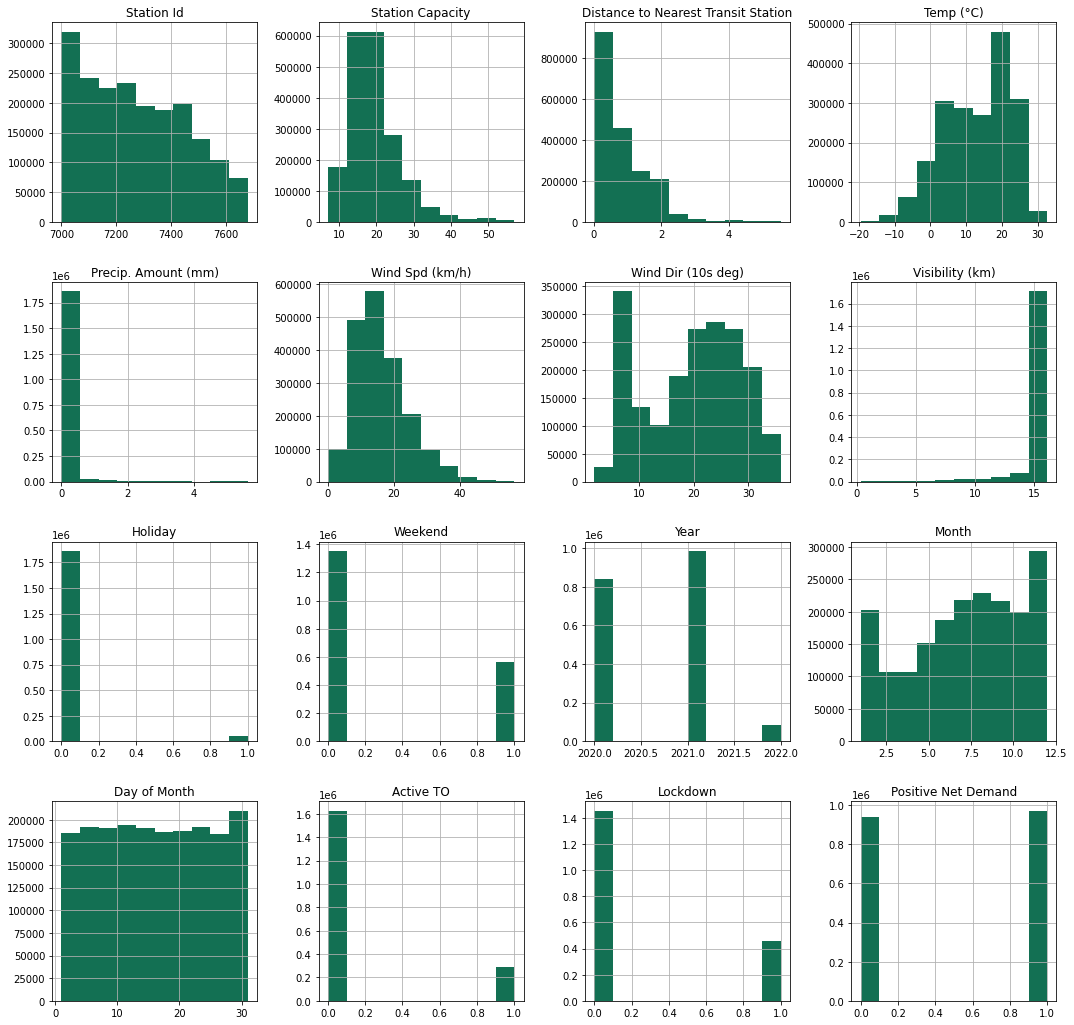

In [ ]:
df.hist(figsize=(18,18), color = '#137053');

### Numerical Feature Summary Statistics

In [ ]:
df.describe()

,Station Id,Station Capacity,Distance to Nearest Transit Station,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Wind Dir (10s deg),Visibility (km),Holiday,Weekend,Year,Month,Day of Month,Active TO,Lockdown,Positive Net Demand
count,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06,1.912438e+06
mean,7.274492e+03,1.922102e+01,8.346906e-01,1.295452e+01,6.196385e-02,1.623261e+01,1.973778e+01,1.550906e+01,2.636791e-02,2.931081e-01,2.020606e+03,7.121290e+00,1.564772e+01,1.491154e-01,2.388909e-01,5.082983e-01
std,1.831887e+02,6.876472e+00,7.692055e-01,9.307706e+00,3.499213e-01,8.137152e+00,8.616382e+00,1.950352e+00,1.602269e-01,4.551877e-01,5.736519e-01,3.075229e+00,8.766458e+00,3.562023e-01,4.264061e-01,4.999313e-01
min,7.000000e+03,7.000000e+00,1.352040e-02,-1.952500e+01,0.000000e+00,0.000000e+00,1.750000e+00,3.500000e-01,0.000000e+00,0.000000e+00,2.020000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.113000e+03,1.500000e+01,2.490548e-01,5.550000e+00,0.000000e+00,1.025000e+01,1.150000e+01,1.610000e+01,0.000000e+00,0.000000e+00,2.020000e+03,5.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.258000e+03,1.900000e+01,5.884515e-01,1.450000e+01,0.000000e+00,1.475000e+01,2.100000e+01,1.610000e+01,0.000000e+00,0.000000e+00,2.021000e+03,7.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,1.000000e+00
75%,7.418000e+03,2.300000e+01,1.227995e+00,2.067500e+01,0.000000e+00,2.075000e+01,2.675000e+01,1.610000e+01,0.000000e+00,1.000000e+00,2.021000e+03,1.000000e+01,2.300000e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.681000e+03,5.700000e+01,5.545345e+00,3.270000e+01,5.625000e+00,5.650000e+01,3.600000e+01,1.610000e+01,1.000000e+00,1.000000e+00,2.022000e+03,1.200000e+01,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00


### Categorical Feature Summary Statistics

In [ ]:
df.describe(include='object')

,Time,Nearest Transit Station Name
count,1912438,1912438
unique,6,60
top,2PM-6PM,King
freq,456973,144656


### Box Plots - Numerical

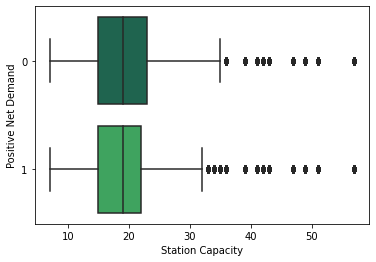

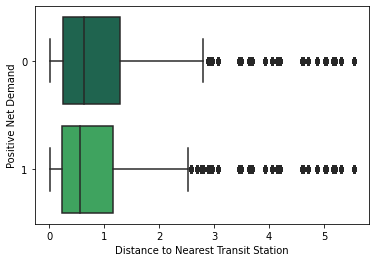

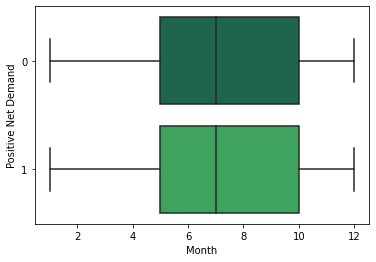

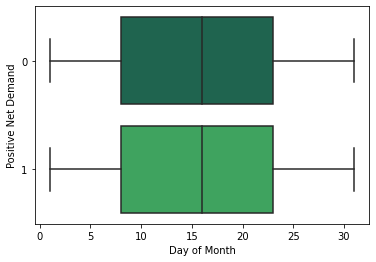

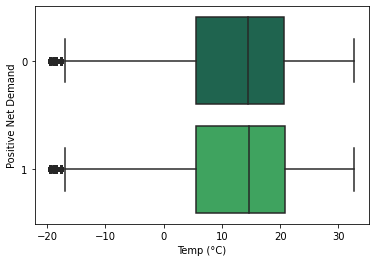

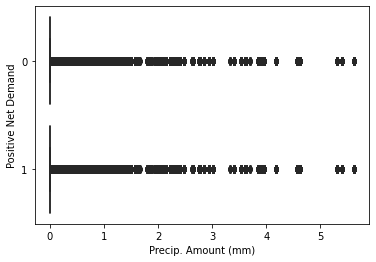

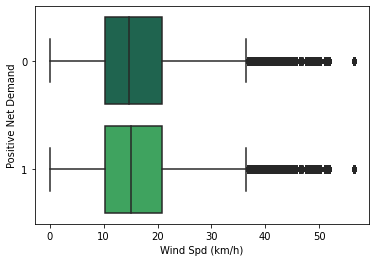

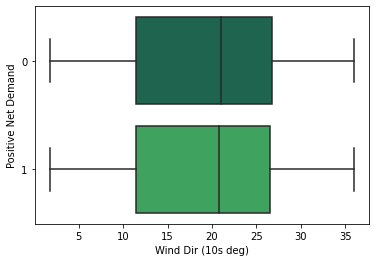

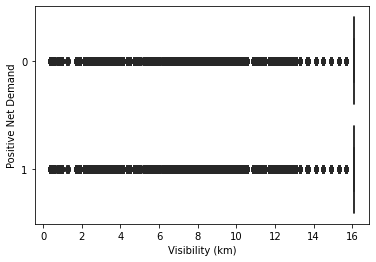

In [ ]:
num_cols = ['Station Capacity',
       'Distance to Nearest Transit Station',
       'Month', 'Day of Month',
       'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)']
colors = ['#137053', '#2eb459']
sns.set_palette(colors)
for col in num_cols:
    sns.boxplot(y = df['Positive Net Demand'].astype('category'), x = col , data=df)
    plt.show()

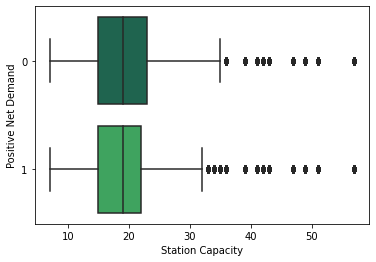

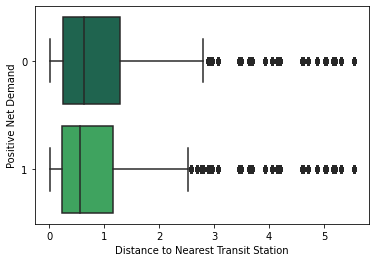

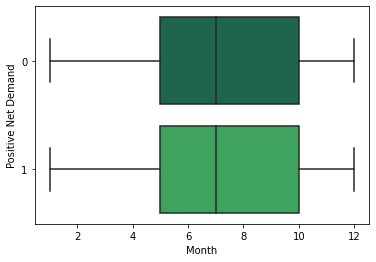

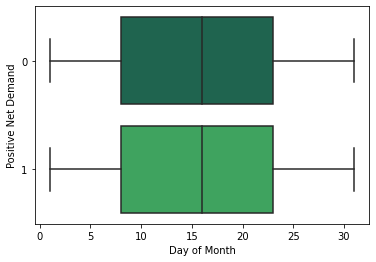

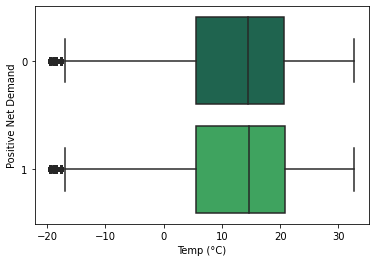

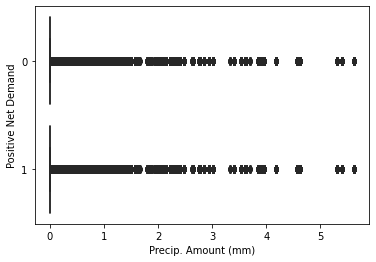

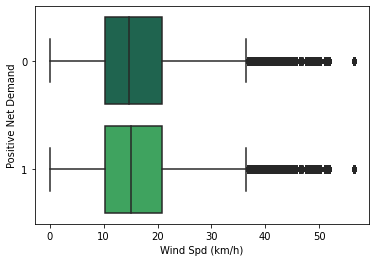

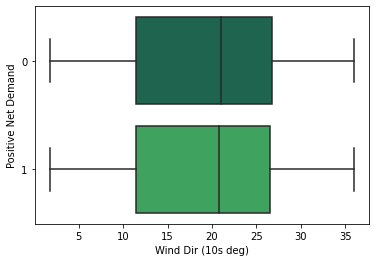

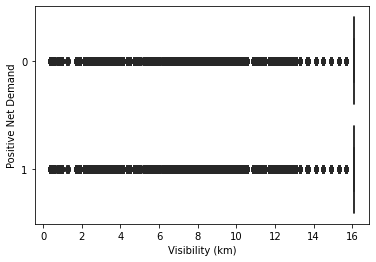

In [ ]:
num_cols = ['Station Capacity',
       'Distance to Nearest Transit Station',
       'Month', 'Day of Month',
       'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
       'Wind Dir (10s deg)', 'Visibility (km)']
for col in num_cols:
    sns.boxplot(y = df['Positive Net Demand'].astype('category'), x = col , data=df)
    plt.show()

### Positive Net Demand vs Categorical Features

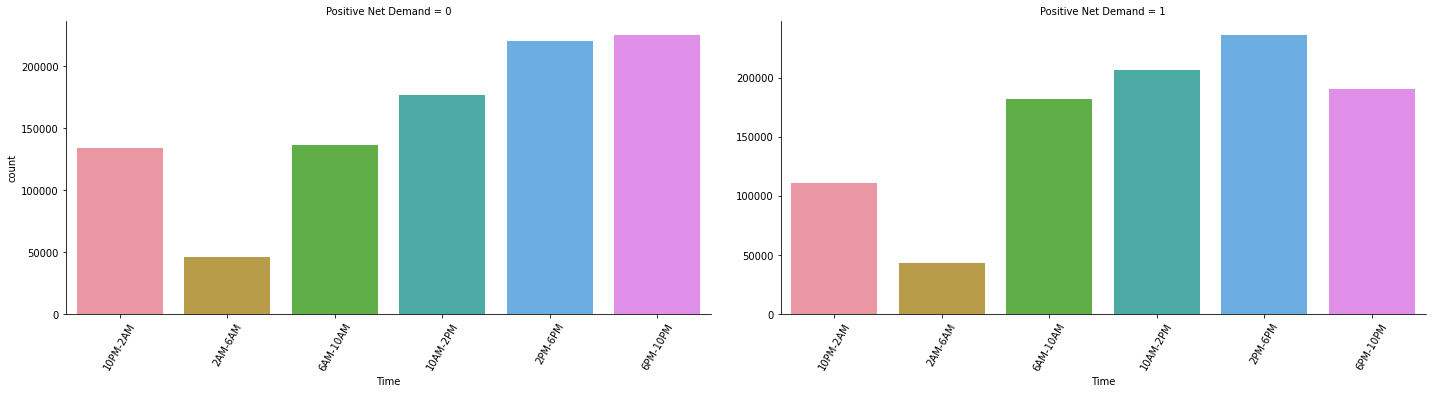

In [ ]:
g = sns.catplot(x = 'Time', kind='count', 
                col = 'Positive Net Demand', data=df, sharey=False,
                order = ['10PM-2AM','2AM-6AM','6AM-10AM', '10AM-2PM','2PM-6PM','6PM-10PM'],
                height=5, aspect=2
                )
g.set_xticklabels(rotation=60);

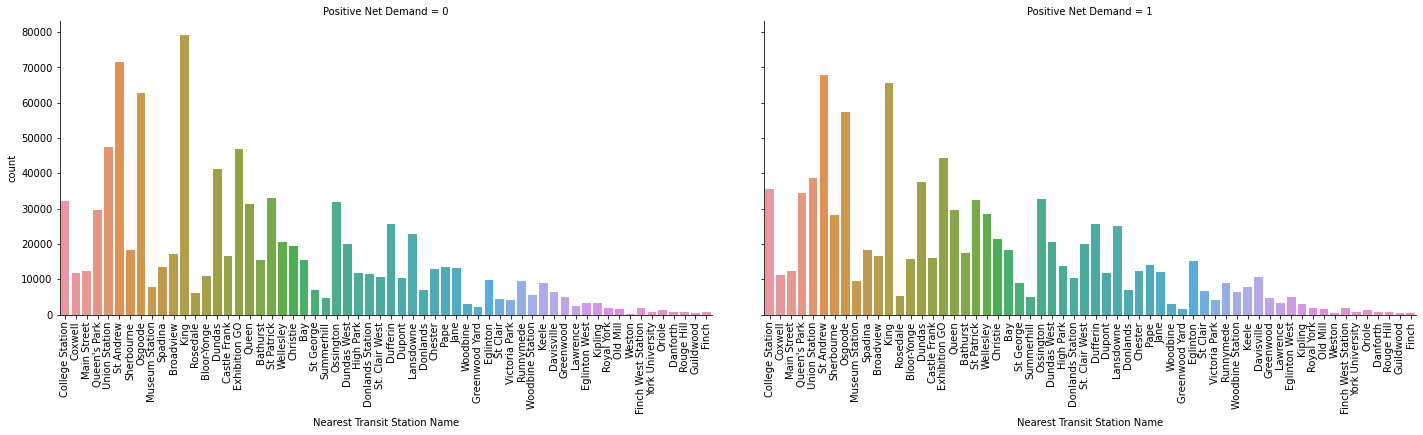

In [ ]:
g = sns.catplot(x = 'Nearest Transit Station Name', kind='count', 
                col = 'Positive Net Demand', data=df, sharey=True,
                height=5, aspect=2
                )
g.set_xticklabels(rotation=90);

### Heatmap Correlation

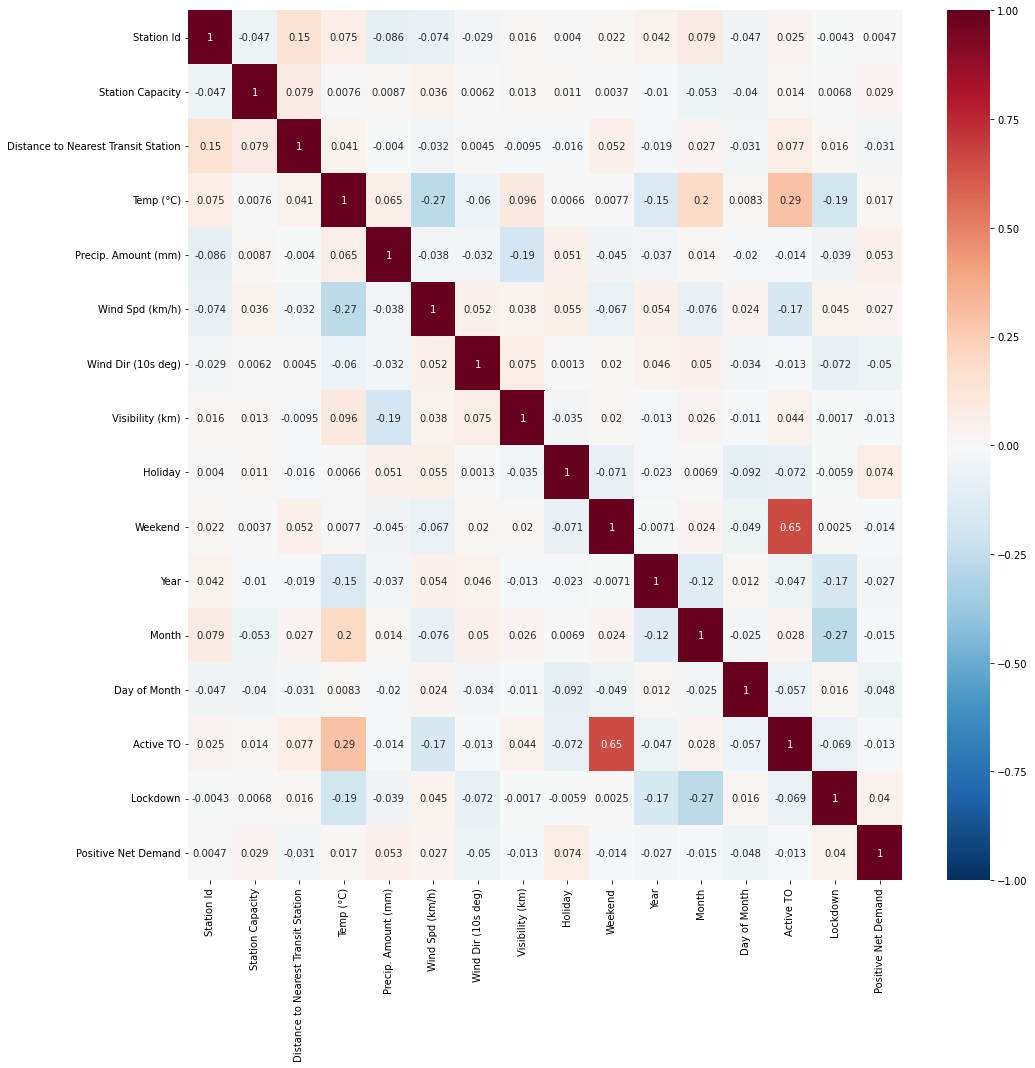

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(df.sample(1000).corr(), cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

In [ ]:
df['Positive Net Demand'] = df['Positive Net Demand'].apply( lambda row: 1 if (row>= 0) else 0 )

Text(0, 0.5, 'Temperature (°C)')

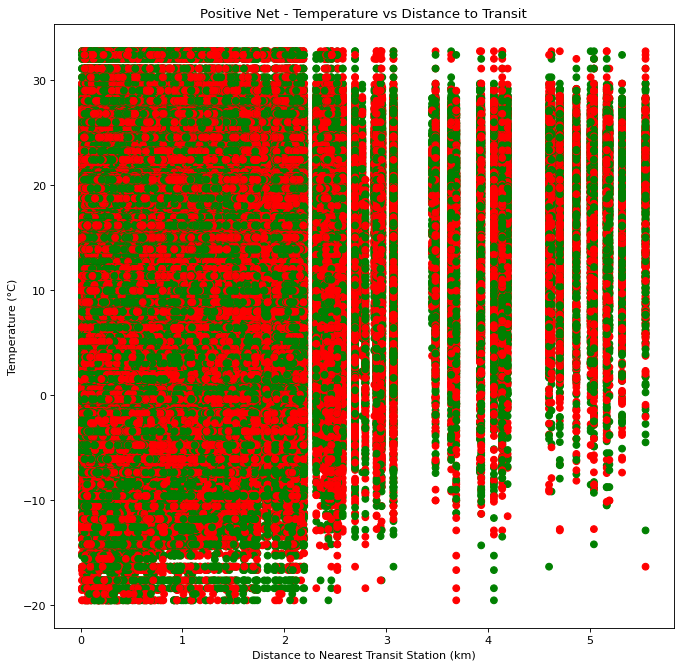

In [9]:
colors = {1:'green', 0: 'red'}
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df['Distance to Nearest Transit Station'], 
            df['Temp (°C)'], 
            c=df['Positive Net Demand'].map(colors),
            )
plt.title('Positive Net - Temperature vs Distance to Transit')
plt.xlabel('Distance to Nearest Transit Station (km)')
plt.ylabel('Temperature (°C)')

Text(0, 0.5, 'Distance to Nearest Transit Station')

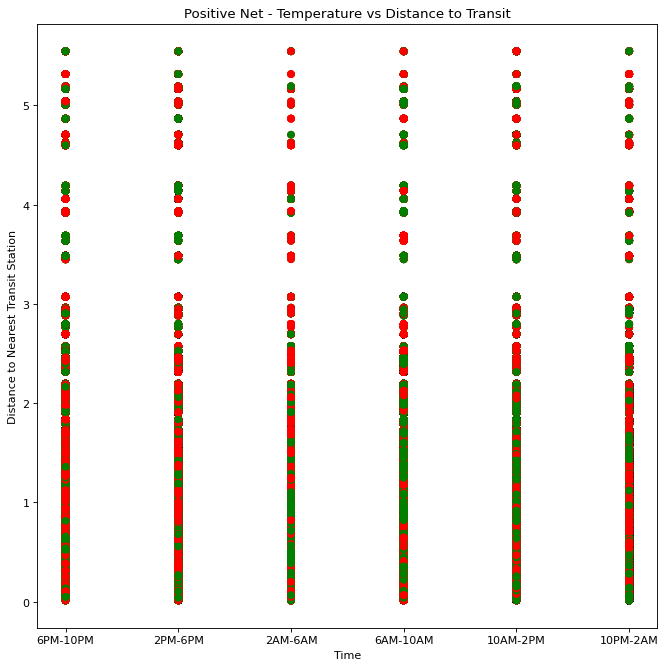

In [10]:
colors = {1:'green', 0: 'red'}
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(
            df['Time'], 
            df['Distance to Nearest Transit Station'], 
            c=df['Positive Net Demand'].map(colors),
            )
plt.title('Positive Net - Temperature vs Distance to Transit')
plt.xlabel('Time')
plt.ylabel('Distance to Nearest Transit Station')

In [ ]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1912438 entries, 831 to 2240790
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Start Station Id       int64  
 1   Binned_Start_Time      object 
 2   capacity               int64  
 3   nearest_transit        object 
 4   POI_distance           float64
 5   Temp (°C)              float64
 6   Precip. Amount (mm)    float64
 7   Wind Spd (km/h)        float64
 8   Wind Dir (10s deg)     float64
 9   Visibility (km)        float64
 10  Holiday                int64  
 11  Is_Weekend             int64  
 12  Year                   int64  
 13  Month                  int64  
 14  Day of Month           object 
 15  Active_TO              int64  
 16  Lockdown_Stay_at_Home  int64  
 17  Positive Net Demand    int64  
dtypes: float64(6), int64(9), object(3)
memory usage: 277.2+ MB
